# 回帰のサンプル
計測を仕事にしてる人向けの雑なstanの使い方の例

回帰の組み方の例と、弱事前分布は「高々これぐらい」という感じで気軽に使おうという話の説明用。

解説記事は別途作成中


In [4]:
#Uncomennt to install the library  on jupyter lab (Unix etc..)
#!pip install mako
#!pip install pystan
#!pip install arviz

#windowsで試すひとはAnaconda/JupyterLabをインストールして以下のようにライブラリを追加
#On windows Anaconda
#Run following in conda terminal on windows
#conda install mako pystan arviz
#conda install libpython m2w64-toolchain -c msys2


from stan_util import get_stan_model,print_code
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

#回帰の結果をプロットする関数（中身は気にしなくて良い）
def plot_rec(X,Y,fit):
    yy=fit.extract("yy")["yy"]
    NOF_PLOT=200
    skip=yy.shape[0]//NOF_PLOT
    if(skip<1):skip=1
    plt.title("Regression lines")
    plt.plot(X,yy[::skip,:].transpose(),color="blue",alpha=0.1)
    plt.plot(X,Y,color="red")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    plt.title("Residue of Y")
    plt.xlabel("X")
    plt.ylabel("Y-yy")
    plt.plot(X,yy[::skip,:].transpose()-Y.reshape(-1,1),color="blue",alpha=0.1)
    plt.show()

# 一定値の計測
重量計のように、一定回数計測して平均値を取る場合

1つ目は事前情報なし（十分に広い一様分布）、２つめは広いガウス分布が事前分布（弱事前分布）

広いガウス分布程度なら影響推定結果には「ほぼ影響ない」ってのがここで重要なポイント。
計算を安定させるためだけの、弱事前分布の設定ってのはよくやる。



========1st: Without prior
1 
2 data{
3     int N;
4     vector[N] Y;
5 
6 
7 }
8 
9 parameters{
10     real mu;
11     real<lower=0> sigma;
12 }
13 model{
14     Y ~ normal(mu,sigma);
15 }
16 
Inference for Stan model: static_6715a455ba02a7a950dd47424ccee846.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.17  5.5e-3    0.2  -0.21   0.03   0.17    0.3   0.57   1304    1.0
sigma   0.84  4.0e-3   0.14   0.61   0.74   0.82   0.91   1.17   1237    1.0
lp__   -5.74    0.04   1.07  -8.74  -6.14   -5.4  -4.98  -4.73    747   1.01

Samples were drawn using NUTS at Fri Aug 14 16:30:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


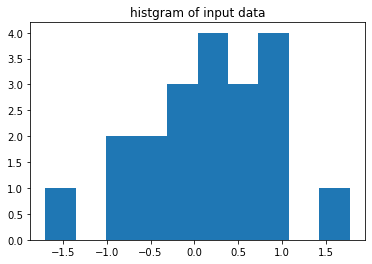

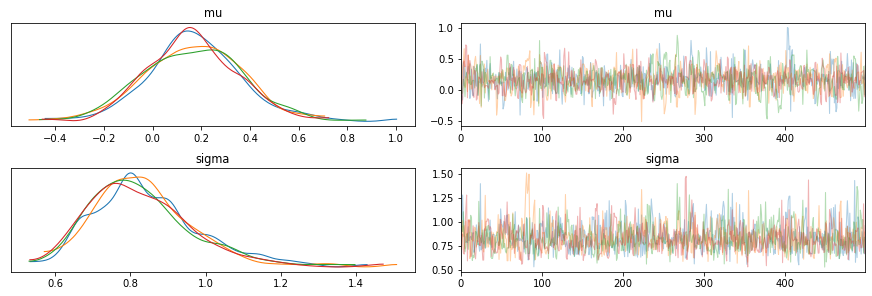

========2nd: With prior for mu and sigma
1 
2 data{
3     int N;
4     vector[N] Y;
5 
6     real mu_u;
7     real mu_s;
8 
9     real sigma_u;
10     real sigma_s;
11 }
12 
13 parameters{
14     real mu;
15     real<lower=0> sigma;
16 }
17 model{
18     mu ~ normal(mu_u,mu_s);
19     sigma ~ normal(sigma_u,sigma_s);
20     Y ~ normal(mu,sigma);
21 }
22 
Inference for Stan model: static_393a401cd3865d5709b119a33f10040c.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      0.17  5.7e-3    0.2  -0.23   0.05   0.17    0.3   0.56   1160    1.0
sigma   0.83  4.2e-3   0.14    0.6   0.73   0.81   0.91   1.15   1102    1.0
lp__   -5.82    0.04   1.05  -8.48  -6.25  -5.49  -5.06  -4.79    613    1.0

Samples were drawn using NUTS at Fri Aug 14 16:30:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the pote

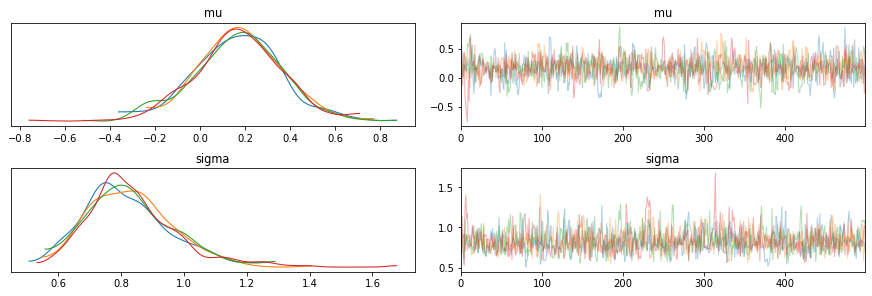

In [15]:
#実験用のシミュレーションデータ
N=20
Y=np.random.randn(N)
plt.title("histgram of input data")
plt.hist(Y)
plt.show()

#事前分布なし
print("========1st: Without prior")

#モデルパラメータ: prio=noneは事前分布なし、 prio=normalはnormal distribution事前分布 (stanコードに展開される)
param=[{"name":"mu","prio":"none","opt":""},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param}
model=get_stan_model("static",d)#stanを直接書くのはたるいので、テンプレートエンジンmakoを通してコード生成
print_code(model) #テンプレートを適用した後のstanコード、このコードをstanに突っ込んでいます
stan_data={
        "N":N,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#以下は結果の出力
print(fit)
#サンプリング後のパラメータの分布出力
az.plot_trace(fit, var_names=("mu","sigma"))
plt.show()


#以下は事前分布ありの場合
print("========2nd: With prior for mu and sigma")
param=[{"name":"mu","prio":"normal","opt":""},
       {"name":"sigma","prio":"normal","opt":"<lower=0>"},
       ]
d={"param":param}
model=get_stan_model("static",d)
print_code(model)

#事前分布のパラメータは「_u」平均値「_s」が標準偏差
stan_data={
        "N":N,
        "Y":Y,
        "mu_u":1, # This have error to true value but almost no effect
        "mu_s":3, # enough broad stddev
        "sigma_u":0,
        "sigma_s":3,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)
print(fit)
az.plot_trace(fit, var_names=("mu","sigma"))
plt.show()


# 線形回帰の例
この程度ならば、事前分布の設定がなくても安定してサンプリングできる。（難しい事を考えたくないときは設定しなくてもよい。）


INFO:pystan:COMPILING THE C++ CODE FOR MODEL reg_388ecdbd733aee7c12dca422974c2a2b NOW.


1 
2 functions{
3     vector func(vector x,real a,real b,real sigma){
4         return a*x + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 }
15 
16 parameters{
17     real a;
18     real b;
19     real<lower=0> sigma;
20 }
21 transformed parameters{
22     vector[N] yy;
23     yy=func(X,a,b,sigma);
24 }
25 
26 model{
27     Y ~ normal(yy,sigma);
28 }
29 
Inference for Stan model: reg_388ecdbd733aee7c12dca422974c2a2b.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   1.05  1.6e-3   0.05   0.95   1.01   1.05   1.09   1.16   1176    1.0
b    -1.4e-3  4.9e-3   0.15  -0.28   -0.1-7.7e-4    0.1   0.29    901    1.0
a        2.0  8.4e-3   0.25   1.51   1.83    2.0   2.18   2.48    897    1.0

Samples were drawn using NUTS at Fri Aug 14 16:31:43 2020.
For each parameter, n_eff is a crude measure of ef

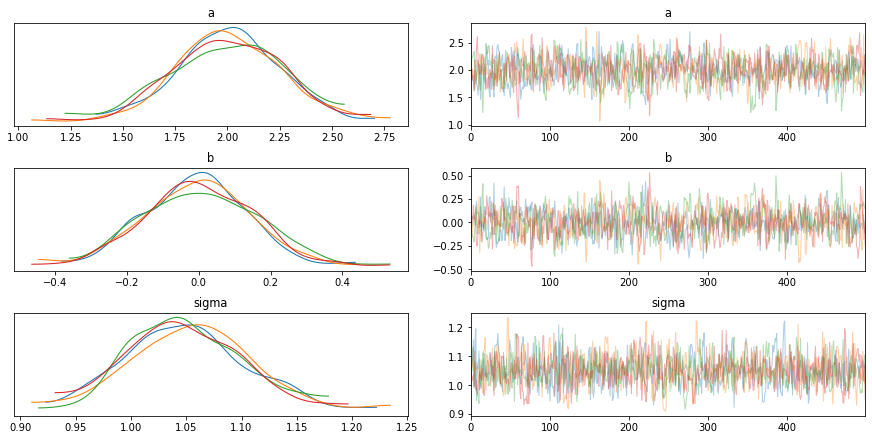

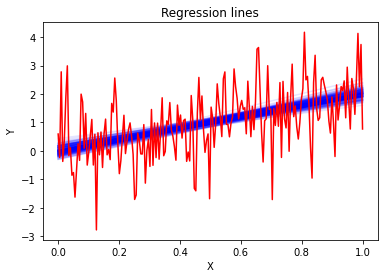

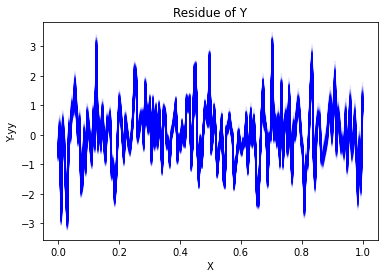

In [16]:
#Make simulation data
N=200
X=np.linspace(0,1,N)
Y=np.random.randn(N)*1 + X*2

#make model
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"return a*x + b;"} #ここでモデル関数ax+bを設定している (線形回帰)
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","sigma"))
plt.show()
plot_rec(X,Y,fit)

# ガウス関数フィッティングの例

こんな簡単なものでも、事前分布なしでは安定にサンプリングできない。⇒つまり弱事前分布は必要！

1つ目は事前情報なし、２つめは広いガウス分布が事前分布

MCMCはどうしても局所解にトラップされる宿命にある。その局所解に落ちないように、パラメータの範囲は高々この程度と指定するのが弱事前分布。
理由有って「弱」ではないカッチリとした事前分布を使う事もあるが、計測装置の特性から求まる分布あったり、
階層モデル(そのうち説明）等を使いたくなったりした後だと思う。


========1st: Without prior
1 
2 functions{
3     vector func(int N,vector x,real a,real b,real u,real s,real sigma){
4         vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14 
15 
16 }
17 
18 parameters{
19     real a;
20     real b;
21     real u;
22     real<lower=0,upper=1000> s;
23     real<lower=0> sigma;
24 }
25 transformed parameters{
26     vector[N] yy;
27     yy=func(N,X,a,b,u,s,sigma);
28 }
29 
30 model{
31     Y ~ normal(yy,sigma);
32 }
33 


Inference for Stan model: reg_27285fad7012e63ff2e41b392a754705.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   1.13    0.08   0.13   0.87   1.05   1.17   1.21    1.3      2   2.33
u     -5.8e8   4.8e8  1.1e9 -4.1e9 -5.5e8 -6.9e4  -0.08  1.8e8      5   2.57
s     365.55  155.86 319.75   0.86   1.28 327.99 638.63 948.11      4   1.37
b       0.31     0.2   0.29  -0.31   0.13   0.44   0.51   0.63      2    3.4
a      2.8e8   2.6e8  5.0e8 -2.9e8 -1.9e4   2.27  4.6e8  1.5e9      4    2.7

Samples were drawn using NUTS at Fri Aug 14 18:51:32 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


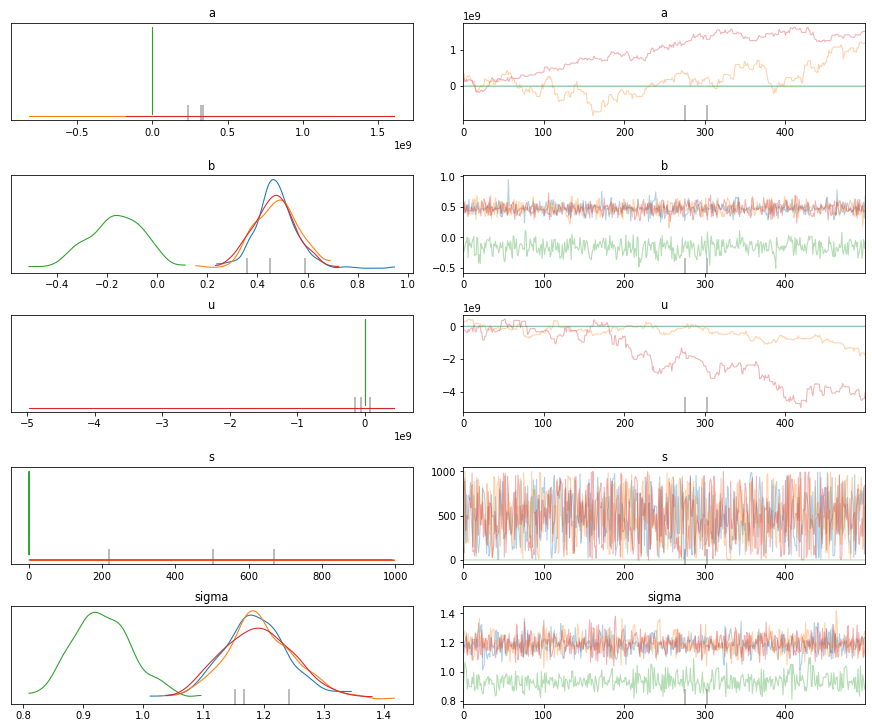

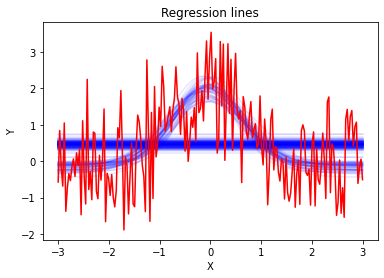

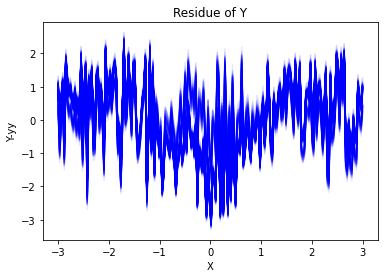

INFO:pystan:COMPILING THE C++ CODE FOR MODEL reg_c812e15baa7815c94219bc19e10cc85c NOW.


========2nd: With prior  u
1 
2 functions{
3     vector func(int N,vector x,real a,real b,real u,real s,real sigma){
4         vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;
5     }
6 }
7 data{
8     int N;
9     vector[N] X;
10     vector[N] Y;
11 
12 
13 
14     real u_u;
15     real u_s;
16 
17     real s_u;
18     real s_s;
19 
20 }
21 
22 parameters{
23     real a;
24     real b;
25     real u;
26     real<lower=0> s;
27     real<lower=0> sigma;
28 }
29 transformed parameters{
30     vector[N] yy;
31     yy=func(N,X,a,b,u,s,sigma);
32 }
33 
34 model{
35     u ~ normal(u_u,u_s);
36     s ~ normal(s_u,s_s);
37     Y ~ normal(yy,sigma);
38 }
39 
Inference for Stan model: reg_c812e15baa7815c94219bc19e10cc85c.
4 chains, each with iter=1500; warmup=1000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma   0.93  1.2e-3   0.05   0.84    0.9   0.93   0.96   1.03   1836    1.0
u   

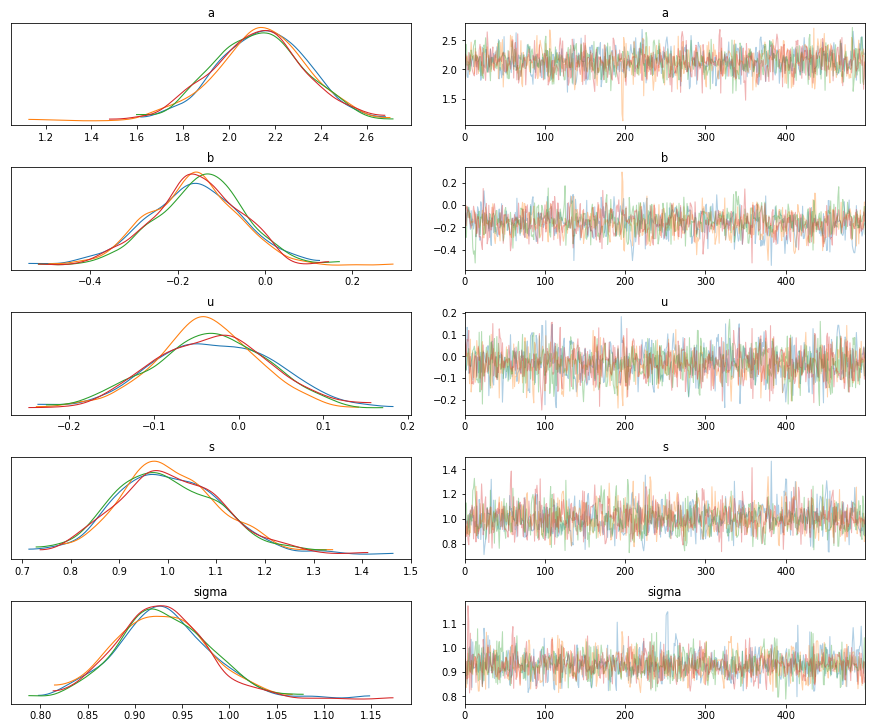

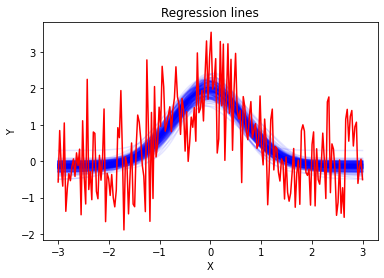

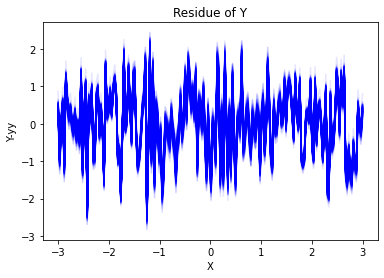

In [31]:
N=200
X=np.linspace(-3,3,N)
Y=np.random.randn(N)+ 2*np.exp(-X**2)

#make model
print("========1st: Without prior")
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"u","prio":"none","opt":""},
       {"name":"s","prio":"none","opt":"<lower=0,upper=1000>"}, #upper is safty limit to avoid nan
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;"}
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","u","s","sigma"))
plt.show()
plot_rec(X,Y,fit)


#make model
print("========2nd: With prior  u,s")
param=[{"name":"a","prio":"none","opt":""},
       {"name":"b","prio":"none","opt":""},
       {"name":"u","prio":"normal","opt":""},
       {"name":"s","prio":"normal","opt":"<lower=0>"},
       {"name":"sigma","prio":"none","opt":"<lower=0>"},
       ]
d={"param":param,"func":"vector[N] xx=(x-u)/s; return a*exp(-xx .* xx ) + b;"}
model=get_stan_model("reg",d)
print_code(model)

#run stan code
stan_data={
        "N":N,
        "X":X,
        "Y":Y,
        "u_u":1, # conatins offset error 
        "u_s":3,
        "s_u":0, #contains offset error
        "s_s":10,
        }

fit=model.sampling(data=stan_data,warmup=1000,iter=1500,chains=4)

#visualize
print(fit.stansummary(pars=list(set(fit.model_pars)-set(["yy"]))))
az.plot_trace(fit, var_names=("a", "b","u","s","sigma"))
plt.show()
plot_rec(X,Y,fit)